<a href="https://www.kaggle.com/code/angelchaudhary/early-stopping-vs-full-training-in-boosting-model?scriptVersionId=292318634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Early Stopping vs Full Training in Boosting Models  
## A Practical Bias–Variance and Generalization Study

# Introduction

Boosting algorithms such as Gradient Boosting, XGBoost, LightGBM, and CatBoost are among the most powerful models in modern machine learning. Their strength comes from sequentially adding weak learners to correct previous mistakes. However, this same strength can easily lead to **overfitting** if the model is allowed to train for too many iterations.

A common question faced by people is:

> **Should we rely on early stopping or train boosting models for a fixed (full) number of iterations?**

While full training might appear thorough, it can:
- Overfit the training data
- Increase training time unnecessarily
- Reduce generalization on unseen data

On the other hand, early stopping introduces a validation-based stopping criterion, which may:
- Improve generalization
- Reduce computational cost
- Prevent performance degradation after an optimal point

This case study aims to compare these two strategies.

---

## Why This Case Study?

Early stopping is frequently mentioned in theory, but:
- It is often treated as a default switch rather than a choice
- Many beginners misuse it or ignore its assumptions
- Interview discussions frequently ask *why* and *when* early stopping works

It is especially useful for understanding:
- Bias–variance tradeoff
- Learning curves in ensemble models
- Practical model selection strategies

---

### What Is Early Stopping?

Early stopping is a regularization technique where training is halted when performance on a validation set stops improving for a predefined number of iterations (called patience).

In boosting models:
- Each iteration adds a new weak learner
- Training loss usually decreases monotonically
- Validation loss often follows a U-shaped curve

Early stopping stops training at the point where:
- Validation performance peaks
- Further training would lead to overfitting

---

### Full Training in Boosting Models

Full training refers to:
- Training the model for a fixed number of estimators (e.g., 500 or 1000 trees)
- No validation-based stopping criterion
- Performance is evaluated only after training completes

While this approach is simpler, it assumes:
- The chosen number of estimators is optimal
- Overfitting risk is minimal

These assumptions often do not hold in real-world datasets.

---

## Approach

In this case study, we will:

1. Select a regression/classification dataset
2. Train a boosting model with:
   - Full training (fixed number of estimators)
   - Early stopping using a validation set
3. Track and compare:
   - Training vs validation performance
   - Generalization gap
   - Training time
4. Visualize learning curves
5. Analyze trade-offs and draw practical conclusions

# LET'S DO IT!!!!
![funny gif](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZDQ2M210OHJuMG8wczA1OWJsOHd1bWRicjJkYnEwNnE3eGdzZWFkNCZlcD12MV9zdGlja2Vyc19zZWFyY2gmY3Q9cw/lGhBlBMIN2XsEteTN3/giphy.gif)

## Dataset Overview

This case study uses publicly available loan data from LendingClub (2007–2010). Each record represents a loan issued to a borrower along with their financial, credit, and behavioral information at the time of approval. From an investor’s perspective, the goal is to **predict whether a borrower will fully repay a loan**, enabling better risk assessment and decision-making.

This dataset is well-suited for boosting models because it contains mixed feature types, non-linear relationships, and real-world noise, making it prone to overfitting and ideal for studying early stopping.


## Target Variable

The target variable is **`not.fully.paid`**:
- `1` → Loan was **not fully paid** (default)
- `0` → Loan was **fully paid**

This is a **binary classification problem**, where the objective is to estimate default risk.

---

#### Feature Summary

Key features include:
- **Credit & financial attributes**: `fico`, `int.rate`, `dti`, `annual.inc`
- **Credit behavior**: `revol.util`, `inq.last.6mths`, `delinq.2yrs`, `pub.rec`
- **Loan characteristics**: `purpose`, `installment`

These features introduce complex interactions that boosting models can effectively learn.

---

#### Why This Dataset for Early Stopping?

Boosting models can easily overfit this dataset by learning noisy borrower patterns and rare default cases.  
This makes it ideal for comparing **full training with a fixed number of estimators** against **early stopping based on validation performance**, with differences that are both measurable and visually clear.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saramah/loan-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-data


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/loan-data/loan_data.csv")

df.head(), df.shape

(   credit.policy             purpose  int.rate  installment  log.annual.inc  \
 0              1  debt_consolidation    0.1189       829.10       11.350407   
 1              1         credit_card    0.1071       228.22       11.082143   
 2              1  debt_consolidation    0.1357       366.86       10.373491   
 3              1  debt_consolidation    0.1008       162.34       11.350407   
 4              1         credit_card    0.1426       102.92       11.299732   
 
      dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
 0  19.48   737        5639.958333      28854        52.1               0   
 1  14.29   707        2760.000000      33623        76.7               0   
 2  11.63   682        4710.000000       3511        25.6               1   
 3   8.10   712        2699.958333      33667        73.2               1   
 4  14.97   667        4066.000000       4740        39.5               0   
 
    delinq.2yrs  pub.rec  not.fully.paid  
 0         

In [6]:
# Target variable
TARGET = "not.fully.paid"

X = df.drop(columns=[TARGET])
y = df[TARGET]

In [7]:
#check target distribution
# Class distribution
y.value_counts()

not.fully.paid
0    8045
1    1533
Name: count, dtype: int64

In [8]:
# Class distribution (percentage)
y.value_counts(normalize=True) * 100

not.fully.paid
0    83.994571
1    16.005429
Name: proportion, dtype: float64

In [9]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()
categorical_cols

['purpose']

In [10]:
# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [11]:
#Train–Validation–Test Split
from sklearn.model_selection import train_test_split

# Train+Val vs Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

# Train vs Validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,test_size=0.25,stratify=y_temp,random_state=42)

X_train.shape, X_val.shape, X_test.shape

((5746, 18), (1916, 18), (1916, 18))

In [12]:
# Check missing values
X_train.isnull().sum().sum()

np.int64(0)

In [13]:
# Ensure column alignment
assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

## Baseline Model

We begin with a baseline LightGBM model trained **without early stopping**.  
The model is trained for a fixed number of trees to establish a reference point for performance.

This baseline helps us understand:
- How the model performs without regularization via early stopping
- The extent of overfitting before introducing validation-based stopping

In [14]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss

In [15]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [16]:
# Baseline parameters (intentionally simple)
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbosity": -1,
    "seed": 42
}

In [17]:
# Train WITHOUT early stopping
baseline_model = lgb.train(params=params,train_set=train_data,num_boost_round=500)

In [18]:
# Baseline evaluation
# Predictions
train_preds = baseline_model.predict(X_train)
val_preds = baseline_model.predict(X_val)
test_preds = baseline_model.predict(X_test)

In [19]:
# AUC scores
print("Train AUC:", roc_auc_score(y_train, train_preds))
print("Validation AUC:", roc_auc_score(y_val, val_preds))
print("Test AUC:", roc_auc_score(y_test, test_preds))

Train AUC: 0.9998099644883818
Validation AUC: 0.621651824124479
Test AUC: 0.6267797385634146


## Baseline Observation

The baseline model achieves an almost perfect AUC on the training set, indicating that it has effectively memorized the training data. However, validation and test AUC scores are significantly lower, revealing a large generalization gap. This confirms severe overfitting caused by training the boosting model for a fixed number of iterations without any stopping criterion.

These results establish a strong motivation for introducing early stopping in the next experiment.

## Early Stopping Experiment

In this experiment, we train the same LightGBM model but enable early stopping using a validation set. Training is stopped when validation performance no longer improves, preventing the model from overfitting and selecting the optimal number of trees automatically.

In [23]:
# Early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

# Train WITH early stopping
early_stop_model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    valid_names=["train", "validation"],
    callbacks=callbacks
)

In [24]:
early_stop_model.best_iteration

20

In [25]:
# evaluation
train_preds_es = early_stop_model.predict(
    X_train, num_iteration=early_stop_model.best_iteration
)

val_preds_es = early_stop_model.predict(
    X_val, num_iteration=early_stop_model.best_iteration
)

test_preds_es = early_stop_model.predict(
    X_test, num_iteration=early_stop_model.best_iteration
)


In [26]:
print("Train AUC (ES):", roc_auc_score(y_train, train_preds_es))
print("Validation AUC (ES):", roc_auc_score(y_val, val_preds_es))
print("Test AUC (ES):", roc_auc_score(y_test, test_preds_es))

Train AUC (ES): 0.7919514663279842
Validation AUC (ES): 0.6707374843864824
Test AUC (ES): 0.6517259389873331


## Early Stopping Impact

Enabling early stopping significantly reduces overfitting by limiting unnecessary tree growth. While training performance decreases, validation and test AUC improve, demonstrating better generalization compared to full training.

## Full Training vs Early Stopping

We now directly compare both strategies to highlight the trade-off between model complexity and generalization.

In [27]:
comparison = pd.DataFrame({
    "Model": ["Full Training", "Early Stopping"],
    "Train AUC": [roc_auc_score(y_train, train_preds),
                  roc_auc_score(y_train, train_preds_es)],
    "Validation AUC": [roc_auc_score(y_val, val_preds),
                       roc_auc_score(y_val, val_preds_es)],
    "Test AUC": [roc_auc_score(y_test, test_preds),
                 roc_auc_score(y_test, test_preds_es)]
})

comparison

,Model,Train AUC,Validation AUC,Test AUC
0,Full Training,0.999810,0.621652,0.626780
1,Early Stopping,0.791951,0.670737,0.651726


### Learning Curves

In [29]:
# Dictionary to store evaluation results
evals_result = {}

callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=False),
    lgb.record_evaluation(evals_result)
]

early_stop_model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    valid_names=["train", "validation"],
    callbacks=callbacks
)

In [30]:
train_auc = evals_result["train"]["auc"]
val_auc = evals_result["validation"]["auc"]

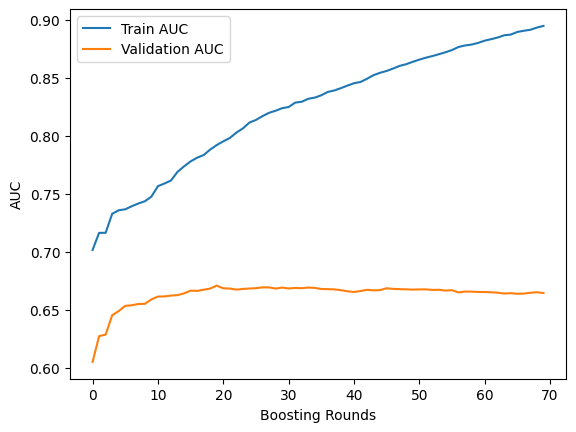

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_auc, label="Train AUC")
plt.plot(val_auc, label="Validation AUC")
plt.xlabel("Boosting Rounds")
plt.ylabel("AUC")
plt.legend()
plt.show()

## Observations

The learning curves show that training AUC increases steadily with additional boosting rounds, indicating that the model continues to fit the training data more closely.

In contrast, validation AUC improves only during the initial rounds and then plateaus, demonstrating that further boosting does not improve generalization. This divergence between training and validation performance is a clear indicator of overfitting.

The comparison table confirms this behavior numerically. While full training achieves near-perfect training AUC, it performs worse on validation and test sets. Early stopping significantly reduces the generalization gap, resulting in higher validation and test AUC despite lower training performance.

Overall, early stopping selects a more optimal model complexity and leads to better real-world performance.

## Final Wrap-Up

This case study explored the impact of **early stopping versus full training** in boosting models using a real-world loan default prediction task.

Through controlled experiments, we observed that training a boosting model for a fixed number of iterations led to severe overfitting. While the fully trained model achieved near-perfect performance on the training data, it failed to generalize well to validation and test sets.

Introducing early stopping fundamentally changed this behavior. By monitoring validation performance and halting training at the optimal point, the model avoided unnecessary complexity, reduced overfitting, and achieved higher validation and test AUC. Although training performance decreased, generalization improved—highlighting the trade-off between model fit and real-world performance.

The learning curves visually reinforced this finding: training performance continued to improve with additional trees, while validation performance plateaued early. Early stopping effectively identified this inflection point and selected a more appropriate model capacity.

Overall, this study demonstrates that early stopping is not merely a training convenience, but a critical regularization technique for boosting models. In practical machine learning workflows, especially on noisy real-world datasets, early stopping should be treated as a default design choice rather than an optional optimization.